In [2]:
import numpy as np
import matplotlib.pyplot as plt
from eigenwell.src.grid import *

/Users/nathanzhao/src/eigenwell/src/grid.py:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(dL)==len(N) == 2, 'must specify 2 elem arr even for 1d sims')


## gradually scaled non-uniform grid

In [3]:

Nfine = [100,100]; #%specify nx, ny for each region
Ncoarse = [50,50];
Ntran =   [50,50];



# 2) specify the dx and dy of each region
dx1 = 0.02; dy1 = 0.02;
dx2 = 0.005; dy2 = 0.005;
dfine = [dx2, dy2];
dcoarse = [dx1, dy1];
dtran = [0 ,0];

#3) stack the vectors
#drt does not have a value...

Nft = np.vstack((Ncoarse, Ntran, Nfine, Ntran, Ncoarse));
drt = np.vstack((dcoarse, dtran, dfine, dtran, dcoarse));

dr_mask = np.ones((np.sum(Nft[:,0]),np.sum(Nft[:,1]),2)); #mask stores dx, dy for every grid cell?

print(Nft)

print(Nft,np.sum(Nft[:,0]),np.sum(Nft[:,1]))

# # we need a base scale dl
# #scale is arbitrary, just take dcoarse;
# dr_reference  = dcoarse;

# #4) construct scaling vectors from this information
# [dx_scale, dy_scale] = generate_nonuniform_scaling(Nft, drt./dr_reference);

# ## calculate Ntot and Ltot
# N = sum(Nft);
# Lx = sum(dr_reference(1)*dx_scale);
# Ly = sum(dr_reference(2)*dy_scale);
# xrange = 0.5*[-Lx, Lx];
# yrange = 0.5*[-Ly, Ly];
# xrange_array = cumsum(dr_reference(1)*dx_scale)-Lx/2;
# yrange_array = cumsum(dr_reference(1)*dy_scale)-Ly/2;
# Nx = N(1); Ny = N(2);
# ## output is a dxscale...dyscale





[[ 50  50]
 [ 50  50]
 [100 100]
 [ 50  50]
 [ 50  50]]
[[ 50  50]
 [ 50  50]
 [100 100]
 [ 50  50]
 [ 50  50]] 300 300


[0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
 0.02  0.02  1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 

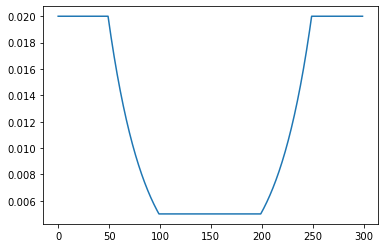

In [6]:
Nx = np.sum(Nft[:,0]);
Ny = np.sum(Nft[:,1]);
dx_scale = np.ones(Nx)
dy_scale = np.ones(Ny);

num_regions = Nft.shape[0]; #iterate through 0,2,4
x0 = y0 = 0;
for i in range(0,num_regions,2):
    dx_scale[x0:x0+Nft[i,0]] = drt[i,0];
    dy_scale[y0:y0+Nft[i,1]] = drt[i,1];
    if(i==num_regions-1): #%no transition after last region
        x0 = x0+Nft[i,0];
        y0 = y0+Nft[i,1];
    else:
        x0 = x0+Nft[i,0]+Nft[i+1,0];
        y0 = y0+Nft[i,1]+Nft[i+1,1];

print(dx_scale)        

x0 = Nft[1,0]; y0 = Nft[1,1];
for i in range(1, num_regions,2): #2:2:num_regions
    dx1 = drt[i-1,0]; dx2 = drt[i+1,0];
    dy1 = drt[i-1,1]; dy2 = drt[i+1,1];
    nxt = Nft[i,0]; nyt = Nft[i,1];

    grading_x = np.logspace(np.log10(dx1), np.log10(dx2), nxt+1);
    grading_y = np.logspace(np.log10(dy1), np.log10(dy2), nyt+1);

    dx_scale[x0-1:x0+nxt] = grading_x;
    dy_scale[y0-1:y0+nyt] = grading_y;
    
    x0 = x0+Nft[i,0]+Nft[i+1,0];
    y0 = y0+Nft[i,1]+Nft[i+1,1];
    
print(dx_scale)

plt.plot(dx_scale)
## ========================================================================
## integrate into an operator
## ========================================================================

[Xs, Ys] = np.meshgrid(dx_scale, dy_scale);
#meshgrid isn't right for y
M = np.prod(Xs.shape)

# we have to this kind of flip because the flattening
# operation (:) doesn't retain row-major order
Ys=Ys.T; Xs = Xs.T;
Fsy = sp.spdiags(Ys.flatten(),0,M,M);
Fsx = sp.spdiags(Xs.flatten(),0,M,M);

# might as well construct the conjugate grid. What is the conjugate grid?
xc = (dx_scale+np.roll(dx_scale,[0,1]))/2;
yc = (dy_scale+np.roll(dy_scale,[0,1]))/2;

[Xc, Yc] = np.meshgrid(xc, yc);
Xc = Xc.T;
Yc = Yc.T;
Fsy_conj = sp.spdiags(Yc.flatten(),0,M,M);
Fsx_conj = sp.spdiags(Xc.flatten(),0,M,M);
    

# Dxf = Fsx^-1*createDws('x', 'f', dL, N);%*Fsx; 
# Dyf = Fsy^-1*createDws('y', 'f', dL, N);%*Fsy;
# Dyb = Fsy_conj^-1*createDws('y', 'b', dL, N);%*Fsx_conj; 
# Dxb = Fsx_conj^-1*createDws('x', 'b', dL, N);%*Fsy_conj; 


<ipython-input-36-37940967c2d5>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Xs.T, Ys.T, np.zeros_like(Xs), cmap = 'cool', linewidth = 0.25, color = 'black')


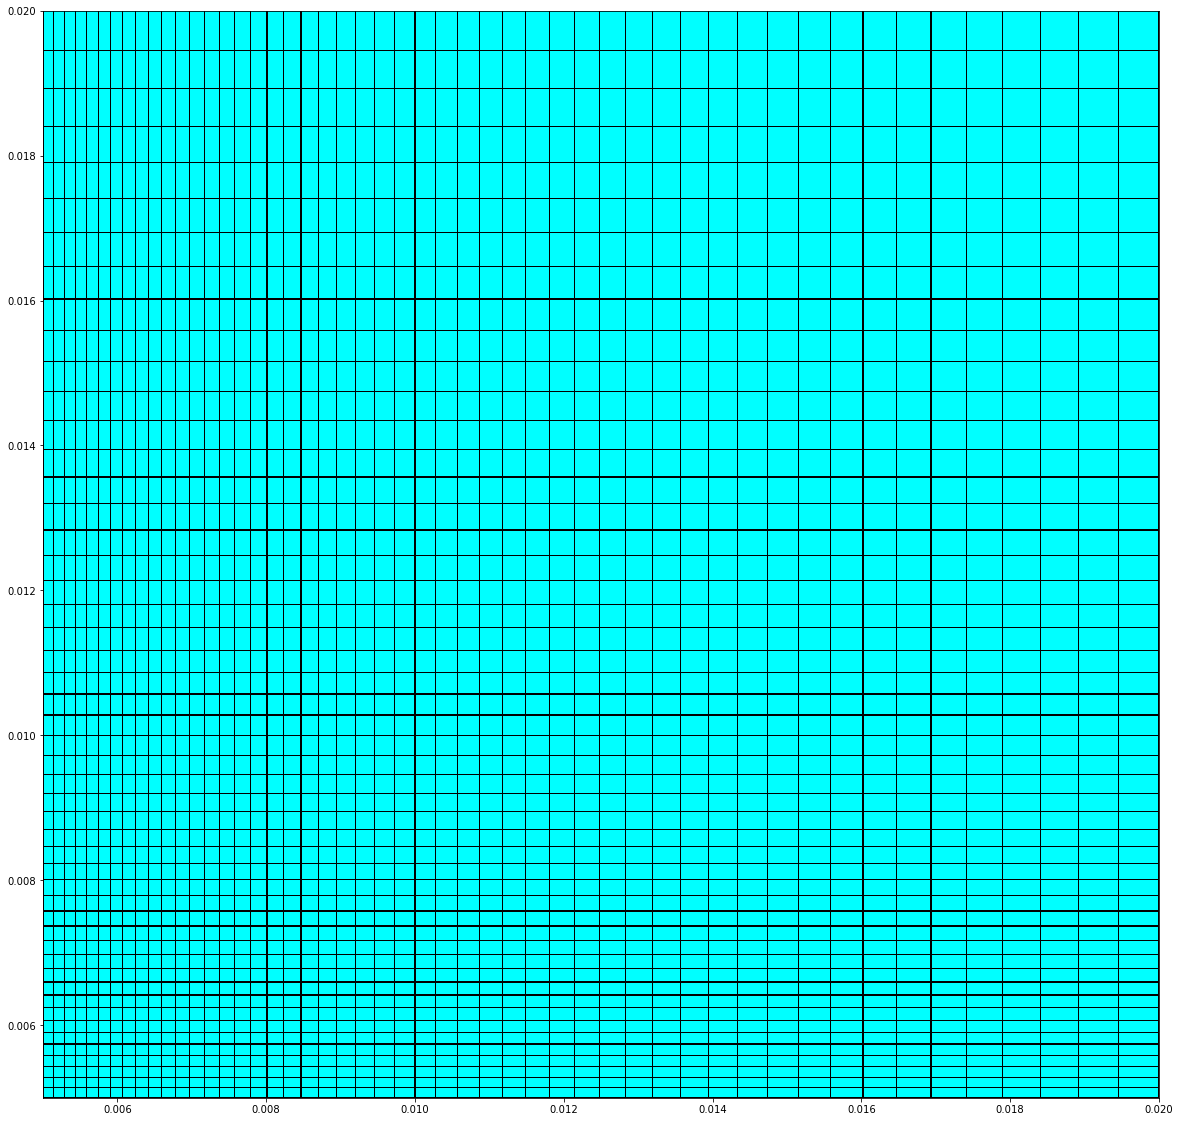

In [36]:
## visualizing a non-uniform grid
plt.figure(figsize = (20,20))
ax = plt.subplot(1,1,1)
plt.pcolormesh(Xs.T, Ys.T, np.zeros_like(Xs), cmap = 'cool', linewidth = 0.25, color = 'black')
plt.show();

In [ ]:
## PML specification
Npml = [20,20];